In [1]:
from ANN import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import matplotlib.colors as mcol
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm_notebook as pbar
from ldamodule import *

In [2]:
def akkuracy(model, data_x, data_y):
    # data_x and data_y are numpy array-of-arrays matrices
    X2 = T.Tensor(data_x).cuda()
    Y2 = T.LongTensor(data_y).cuda()   
    oupt = model(X2)            # a Tensor of floats
    pred_y = T.argmax(oupt,dim=-1)
    print(len(pred_y), len(X2))
    num_correct = T.sum(Y2==pred_y)  # a Tensor
    acc = (num_correct.item() * 100.0 / len(data_y))  # scalar
    return acc

In [11]:
# io train
# X = []
# Y = []
# with open("synthetic_dataset/train.txt") as f:
#     reader = csv.reader(f)
#     for row in reader:
#         X.append([float(row[0]), float(row[1])])
#         Y.append([int(row[2])-1])
                
# # PredictorScaler=StandardScaler()
# # X = PredictorScaler.fit_transform(X)
# X = np.array(X, dtype=np.float64)
# Y = np.array(Y, dtype=np.float64)

X = []
Y = []
classes = os.listdir("Handwriting_Data/")
for i in range(len(classes)):
    _class = classes[i]
    inputfiles = os.listdir("Handwriting_Data/"+_class+"/train/")
    for inputfile in inputfiles:
        with open("Handwriting_Data/"+_class+"/train/" + inputfile) as f:
            reader = np.genfromtxt(f, delimiter=" ")
            length = int(reader[0])
            data = []
            for j in range(length):
                data.append([reader[2*j+1],reader[2*j+2]])
            X.append([length,data])
            Y.append(i)
# lengths
lengths = [x for [x,_] in X]
mean_length = np.mean(lengths)

In [4]:
# io dev
X_dev = []
Y_dev = []
classes = os.listdir("Handwriting_Data/")
for i in range(len(classes)):
    _class = classes[i]
    inputfiles = os.listdir("Handwriting_Data/"+_class+"/dev/")
    for inputfile in inputfiles:
        with open("Handwriting_Data/"+_class+"/dev/" + inputfile) as f:
            reader = np.genfromtxt(f, delimiter=" ")
            for row in reader:
                X_dev.append(row)
            Y_dev.append(i)
X_dev = np.array(X_dev, dtype=np.float64)
Y_dev = np.array(Y_dev, dtype=np.int16)
X_dev = X_dev.reshape(-1,23*36)
X_dev.shape,Y_dev.shape

((348, 828), (348,))

In [5]:
# flda = FDA(X, Y, 2)
# X = flda.transform_data(X)
# X_dev = flda.transform_data(X_dev)
# X.shape, Y.shape, X_dev.shape, Y_dev.shape

In [6]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()

# create df_Y
df_Y = pd.DataFrame(np.array(Y,dtype=int))

#perform one-hot encoding on  Y
encoder_df = pd.DataFrame(encoder.fit_transform(Y.reshape(-1,1)).toarray())
Yhat = encoder_df.to_numpy()

In [10]:
net = ANN(dataset_type='image', args=[23*36,23*72,23*36,23*18,23*9]).to('cuda')
net = net.train()  # set training mode
lrn_rate = 1e-5
bat_size = 100
loss_func = T.nn.CrossEntropyLoss().cuda()  # softmax() + Categorical CE
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)
max_epochs = 400000
n_items = len(X)
batcher = Batcher(n_items, bat_size)

In [11]:
losses = []
train_acc = []
test_acc = []
for epoch in pbar(range(max_epochs)):
    loss = 0.
    if epoch > 0 and epoch % (10) == 0:
        print('epoch = %6d' % epoch, end='')
        print('  batch loss = %7.4f' % np.average(losses[-10:]), end='')
        acc = akkuracy(net, X, Y)
        print(' train accuracy = %0.2f' % acc, end='')
        train_acc.append(acc)
        acc = akkuracy(net, X_dev, Y_dev)
        print(' dev accuracy = %0.2f' % acc)
        test_acc.append(acc)
        if(acc > 70):
            break
    for curr_bat in batcher:
        X1 = T.Tensor(X[curr_bat]).cuda()
        Y1 = T.LongTensor(Y[curr_bat]).cuda()
        optimizer.zero_grad()
        oupt = net(X1)
        loss_obj = loss_func(oupt, Y1)
        loss_obj.backward()
        loss += loss_obj.item()
        optimizer.step()
    # loss /= batcher.num_items
    losses.append(loss)
    # if(loss < 7):
    #     break

  0%|          | 0/400000 [00:00<?, ?it/s]

epoch =     10  batch loss = 17.99331210 1210
 train accuracy = 64.05348 348
 dev accuracy = 53.74
epoch =     20  batch loss = 16.21541210 1210
 train accuracy = 69.34348 348
 dev accuracy = 57.18
epoch =     30  batch loss = 15.32711210 1210
 train accuracy = 73.31348 348
 dev accuracy = 59.20
epoch =     40  batch loss = 14.76401210 1210
 train accuracy = 76.53348 348
 dev accuracy = 60.06
epoch =     50  batch loss = 14.33011210 1210
 train accuracy = 77.02348 348
 dev accuracy = 62.07
epoch =     60  batch loss = 13.99401210 1210
 train accuracy = 81.16348 348
 dev accuracy = 63.22
epoch =     70  batch loss = 13.71231210 1210
 train accuracy = 82.73348 348
 dev accuracy = 62.64
epoch =     80  batch loss = 13.47421210 1210
 train accuracy = 84.63348 348
 dev accuracy = 61.78
epoch =     90  batch loss = 13.27941210 1210
 train accuracy = 85.29348 348
 dev accuracy = 62.07
epoch =    100  batch loss = 13.12181210 1210
 train accuracy = 86.12348 348
 dev accuracy = 61.21
epoch =   

KeyboardInterrupt: 

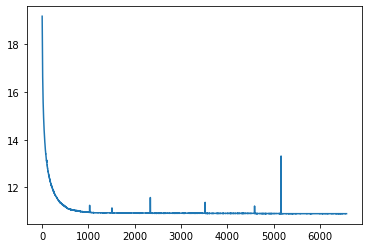

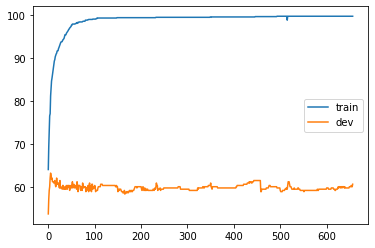

In [14]:
plt.plot(losses)
plt.show()
plt.plot(train_acc,label='train')
plt.plot(test_acc, label='dev')
plt.legend()
plt.show()

In [26]:
def plot_decision_boundary(X, y,X_orig, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X_orig[:,0].min() - 1, X_orig[:,0].max() + 1
    ymin, ymax = X_orig[:,1].min() - 1, X_orig[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    # xx = PredictorScaler.transform(xx)
    # yy = PredictorScaler.transform(yy)
    # t = PredictorScaler.transform(np.c_[xx.ravel(), yy.ravel()])
    t = np.c_[xx.ravel(), yy.ravel()]
    labels = np.argmax(model.forward(T.Tensor(t).cuda()).cpu().detach().numpy(), axis=1)

    # hard labels
    # labels_h_ind_1 = np.where(np.argmax(labels) == 1)
    # labels_h_ind_0 = np.where(labels <= 0.5)
    # labels_h = np.zeros(labels.shape)
    # labels_h[labels_h_ind_1] = 1
    # labels_h[labels_h_ind_0] = 0

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    # ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    # train_labels = model.predict(X)
    ax.scatter(X_orig[:,0], X_orig[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

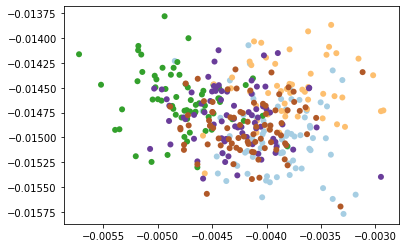

In [27]:
# X_dev_orig = PredictorScaler.inverse_transform(X_dev)
plot_decision_boundary(X_dev, Y_dev,X_dev, net)